In [3]:
%ls

Fig3-1.xls                  lgb_450_20170501.csv
PerformanceGraphExport.xls  macro.csv
QRUN628BIS.csv              sample_submission.csv
Untitled.ipynb              sample_submission.csv.zip
Untitled1.ipynb             script.py
Xgboost.ipynb               test.csv
data_clean.ipynb            test_featured.csv
data_clean.py               train.csv
features_importance.png     train_featured.csv


In [896]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt


In [897]:
train=pd.read_csv('train.csv',parse_dates=['timestamp'])



In [898]:
train.shape

(30471, 292)

In [899]:
dup_subset=['full_sq',
 'life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'area_m',
 'raion_popul',
 'green_zone_part',
 'indust_part']
show_col=['id']+dup_subset
duplicate=train[train.duplicated(subset=dup_subset,keep=False)][show_col]
duplicate.head()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,area_m,raion_popul,green_zone_part,indust_part
22,23,48,34.0,6.0,NaN,NaN,NaN,NaN,NaN,9.249237e+06,156377,0.374068,0.000000
39,40,33,18.0,9.0,NaN,NaN,NaN,NaN,NaN,1.051837e+07,118945,0.334905,0.012339
40,41,45,30.0,5.0,NaN,NaN,NaN,NaN,NaN,1.249544e+07,91100,0.027651,0.341072
42,43,40,25.0,3.0,NaN,NaN,NaN,NaN,NaN,5.586343e+06,83502,0.086220,0.040243
69,70,45,30.0,6.0,NaN,NaN,NaN,NaN,NaN,7.462270e+06,129207,0.387100,0.007720


In [598]:
 def nan_equal(a,b):
...:     try:
...:         np.testing.assert_equal(a,b)
...:     except AssertionError:
...:         return False
...:     return True

In [472]:
def find_duplicate(dup_data,dup_set,undup_set):
    dup_first=[]
    num=len(dup_data)
    m=len(dup_set)
    print num
    duplist= defaultdict(list)
    for raw_index in dup_data.index:
        flag=0
        raw=dup_data.loc[raw_index]
        #print ra
        if dup_first:
            for first_index in dup_first:
                #print 'in circle'
                #print first_index
                first=dup_data[dup_data['id']==first_index]
                #print first
                #print first[dup_set]
                if nan_equal(raw[dup_set].tolist(),first[dup_set].values.reshape(m).tolist())==False:
                    continue  
                    
                else: 
                    #print 'yes'
                    duplist[int(first[undup_set].values)].append(int(raw[undup_set].values))
                    #dup_first=dup_first.append(raw)
                    flag=1
                    break
            if(flag==0):
                        #print'after break'
                        duplist[int(raw[undup_set].values)]=[] 
                        dup_first.append(int(raw[undup_set].values))
        else:
            dup_first.append(int(raw[undup_set].values))
            duplist[int(raw[undup_set].values)]=[]
        #print"dupfirst:" 
        #print duplist
        #print dup_first
    return duplist,dup_first                                                                     

In [900]:
train['logPrice']=np.log1p(train['price_doc'].values)


In [901]:
train['year']=train['timestamp'].dt.year
train['month']=train['timestamp'].dt.month
train['monthlable']=(train['month']-8)+(train['year']-2011)*12

In [902]:
need_columns=['id','logPrice','monthlable']

In [903]:
train_lr=train[need_columns]

In [905]:
xy_col=range(0,47)
X=pd.DataFrame(columns=xy_col)
X


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46


In [906]:
def construct_max(duplicatelist,X):
        Y=[]
        index=0
         #for pair in duplicatelist.iteritems():
        for key,value in duplicatelist.iteritems():
            position=0
            
            sort_pair=[key]+value
            length=len(sort_pair)
            #print length
            #print sort_pair
            while(position!=length-1):
                #print sort_pair[position]
                #print sort_pair[position+1]
                pre_series=train_lr[train_lr['id']==sort_pair[position]]
                #print pre_series
                sub_series=train_lr[train_lr['id']==sort_pair[position+1]]
                tem=float(sub_series['logPrice'].values-pre_series['logPrice'].values)
                #print tem
                Y.append(tem)
                pre_month=pre_series['monthlable']
                sub_month=sub_series['monthlable']
                X.loc[index,pre_month]=-1
                X.loc[index,sub_month]=1
                index+=1
                position+=1
        X=X.fillna(0)        
        return X,Y   

In [907]:
matrix_x,matrix_y=construct_max(duplicate_list,X) 

In [908]:
print train_lr.loc[8192]
print train_lr.loc[8389]


id            8195.000000
logPrice        15.481107
monthlable      21.000000
Name: 8192, dtype: float64
id            8392.000000
logPrice        15.481107
monthlable      22.000000
Name: 8389, dtype: float64


In [909]:
train_x=matrix_x[:]
train_y=matrix_y
train_y

[0.0,
 0.030912477313169262,
 0.0,
 0.01156082022776772,
 0.0773866496970026,
 0.021053405593956853,
 0.0,
 0.1552928613923399,
 -0.12725945916589865,
 0.0,
 0.0,
 0.11778298010085386,
 0.03174869327425789,
 0.0,
 0.20100502704432976,
 0.0,
 -0.0005342355258903808,
 -0.012463047432540009,
 -0.7884571785461318,
 0.13491929025605565,
 -0.029558796500239737,
 0.18647945161625756,
 1.741705047902487,
 0.09884582241356199,
 0.14048362547508297,
 -0.13509777852844707,
 0.0,
 0.15415065601773748,
 0.0,
 0.0,
 -0.0870113618381172,
 0.0757118053499326,
 0.06062460956153615,
 0.011173298101248008,
 -0.12405262665740402,
 0.12405262665740402,
 0.0,
 0.08552215880116165,
 -1.6677060092378042,
 0.02363359323099523,
 0.02447221011052747,
 0.0,
 0.06001799771544647,
 0.01016315226797282,
 -0.10178267702884014,
 0.5436153301015523,
 0.0,
 0.0,
 0.03533043104048694,
 -0.1069215253529805,
 0.07847160340838144,
 0.06768935934711351,
 0.6931469305600384,
 -0.05884049136492564,
 0.0,
 -0.1523174685566282,


In [910]:
from sklearn import datasets, linear_model
regr = linear_model.LinearRegression()
regr.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [912]:
print('Coefficients: \n', regr.coef_)
coef=regr.coef_
price_index=np.exp(coef)
print price_index


('Coefficients: \n', array([ 0.        , -0.12979167, -0.06225729,  0.04301432, -0.54546668,
       -0.0279693 , -0.19891019, -0.01912201, -0.29596432, -0.11190281,
       -0.0337845 ,  0.06060359, -0.07259107, -0.05360242, -0.0143999 ,
        0.0098536 , -0.01415826, -0.04802682, -0.02340639, -0.01028776,
       -0.0345184 , -0.00614133,  0.01029633,  0.01805034,  0.02419643,
       -0.01011189, -0.04899105,  0.04365876,  0.00166993, -0.02839624,
       -0.06715049, -0.01279624, -0.04224324,  0.02696803, -0.01755245,
        0.03320922, -0.12555446,  0.0474596 ,  0.03434393,  0.0159236 ,
        0.07032679,  0.11852761,  0.17623506,  0.08682129,  0.08784605,
        0.09067468,  0.03988077]))
[ 1.          0.87827838  0.9396411   1.04395284  0.57957125  0.97241822
  0.8196235   0.98105966  0.74381396  0.89413115  0.96677982  1.06247765
  0.92998105  0.94780886  0.98570328  1.00990231  0.9859415   0.95310823
  0.97686542  0.98976498  0.96607057  0.99387749  1.01034952  1.01821423
  1.

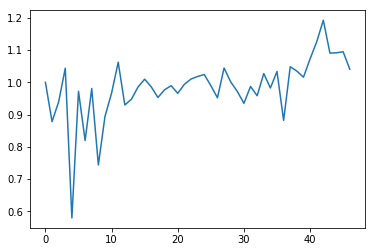

In [913]:
plt.plot(price_index)
plt.show()

In [914]:
month_price_index={v: k for v, k in enumerate(price_index)}
month_priceindex=pd.DataFrame.from_dict(month_price_index,orient='index')
month_priceindex.columns = ['priceindex']
month_priceindex=month_priceindex.reset_index().rename(columns={'index': 'monthlable'})


In [915]:
train=pd.merge(train,month_priceindex,on='monthlable',how='left')


In [916]:
train['price_doc']=train['price_doc']/train['priceindex']


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,logPrice,year,month,monthlable,priceindex
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,1,0,52,4,5.850000e+06,15.581952,2011,8,0,1.000000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,1,10,66,14,6.000000e+06,15.607270,2011,8,0,1.000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,4,67,10,5.700000e+06,15.555977,2011,8,0,1.000000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,0,0,26,3,1.491554e+07,16.388123,2011,9,1,0.878278
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,2,91,195,14,1.859485e+07,16.608603,2011,9,1,0.878278
5,6,2011-09-06,67,46.0,14.0,NaN,NaN,NaN,NaN,NaN,...,1,20,113,17,1.036118e+07,16.023785,2011,9,1,0.878278
6,7,2011-09-08,25,14.0,10.0,NaN,NaN,NaN,NaN,NaN,...,1,27,127,8,6.262251e+06,15.520259,2011,9,1,0.878278
7,8,2011-09-09,44,44.0,5.0,NaN,NaN,NaN,NaN,NaN,...,1,0,47,4,2.277182e+06,14.508658,2011,9,1,0.878278
8,9,2011-09-10,42,27.0,5.0,NaN,NaN,NaN,NaN,NaN,...,1,3,85,11,6.034533e+06,15.483218,2011,9,1,0.878278
9,10,2011-09-13,36,21.0,9.0,NaN,NaN,NaN,NaN,NaN,...,1,3,67,1,2.277182e+06,14.508658,2011,9,1,0.878278


In [917]:
train.drop(['logPrice','year','month','monthlable','priceindex'],axis=1,inplace=True)

In [918]:
outputFile = 'train_priceindex.csv'
train.to_csv(outputFile,index=False)